
Training SVM with linear kernel...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ...............................................C=10; total time=   0.0s
[CV] END ....

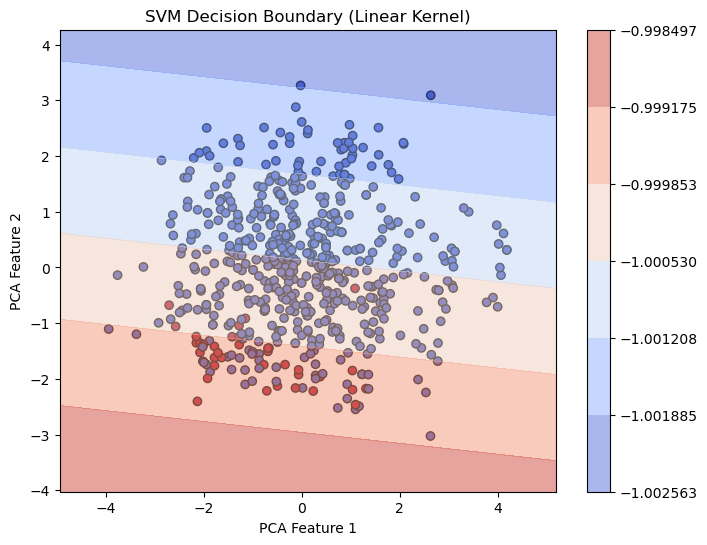


Comparison of Kernels:
        accuracy  precision    recall       auc
linear  0.986395   0.818182  1.000000  0.992754
rbf     0.979592   0.875000  0.777778  0.963768


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv('Sentiment.csv')
data_cleaned = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Timestamp', 'User', 'Platform', 'Hashtags', 'Text', 'Country'])


data_cleaned['Sentiment'] = data['Sentiment'].apply(lambda x: 1 if x.strip().lower() == 'positive' else 0)


X = data_cleaned.drop(columns=['Sentiment'])
y = data_cleaned['Sentiment']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


kernels = ['linear', 'rbf']
results = {}

for kernel in kernels:
    print(f"\nTraining SVM with {kernel} kernel...")
    svc = SVC(kernel=kernel, probability=True, random_state=42)
    
    
    param_grid = {'C': [0.1, 1, 10]}
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=2)
    grid_search.fit(X_train, y_train)
    
    best_svc = grid_search.best_estimator_
    y_pred = best_svc.predict(X_test)
    y_prob = best_svc.predict_proba(X_test)[:, 1]
    
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results[kernel] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'auc': auc}
    
    print(f"Kernel: {kernel}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, AUC: {auc:.2f}")


from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

svc = SVC(kernel='linear', probability=True, random_state=42)
svc.fit(X_train_2d, y_train)

plt.figure(figsize=(8, 6))
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')
plt.title('SVM Decision Boundary (Linear Kernel)')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')


import numpy as np

xx, yy = np.meshgrid(np.linspace(X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1, 100),
                     np.linspace(X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1, 100))
Z = svc.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 7), alpha=0.5, cmap='coolwarm')
plt.colorbar()
plt.show()


print("\nComparison of Kernels:")
comparison_df = pd.DataFrame(results).T
print(comparison_df)
